# Yolo v1

Yolo v1 provides many fundamental and important concepts for oriented bounding boxes. It is worth learning.

In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

from fastcore.all import *

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

## Utils

Some helpful utilities that can help us.

In [2]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

IoU: 0.6000


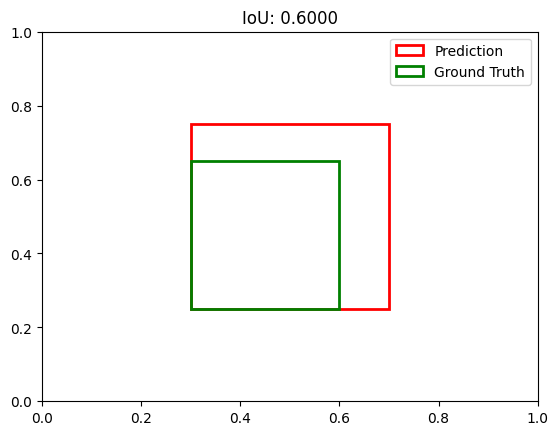

In [3]:
# Create example boxes
# Format: [x, y, width, height] in midpoint format
box1 = torch.tensor([0.5, 0.5, 0.4, 0.5])  # Center at (0.5, 0.5) with width=0.4, height=0.5
box2 = torch.tensor([0.45, 0.45, 0.3, 0.4])  # Center at (0.45, 0.45) with width=0.3, height=0.4

# Add batch dimension
boxes_pred = box1.unsqueeze(0)  # Shape: [1, 4]
boxes_label = box2.unsqueeze(0)  # Shape: [1, 4]

# Calculate IoU
iou = intersection_over_union(boxes_pred, boxes_label, box_format="midpoint")
print(f"IoU: {iou.item():.4f}")

# Visualize the boxes
fig, ax = plt.subplots(1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Convert to corner format for plotting
def midpoint_to_corners(box):
    x, y, w, h = box
    x1 = x - w/2
    y1 = y - h/2
    return x1, y1, w, h

# Plot box1 (prediction)
x1, y1, w, h = midpoint_to_corners(box1)
rect1 = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none', label='Prediction')
ax.add_patch(rect1)

# Plot box2 (ground truth)
x1, y1, w, h = midpoint_to_corners(box2)
rect2 = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='g', facecolor='none', label='Ground Truth')
ax.add_patch(rect2)

ax.legend()
plt.title(f"IoU: {iou.item():.4f}")
plt.show()

In [4]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [5]:
bboxes = [
    [0, 0.9, 0.2, 0.2, 0.6, 0.6],  # High confidence box
    [0, 0.8, 0.25, 0.25, 0.65, 0.65],  # Overlapping box, same class
    [0, 0.7, 0.5, 0.5, 0.9, 0.9],  # Different location, same class
    [1, 0.95, 0.2, 0.2, 0.6, 0.6],  # Same location, different class
    [0, 0.3, 0.2, 0.2, 0.6, 0.6],  # Low confidence, will be filtered
]
threshold=0.5
bboxes = [box for box in bboxes if box[1] > threshold]
bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
bboxes

[[1, 0.95, 0.2, 0.2, 0.6, 0.6],
 [0, 0.9, 0.2, 0.2, 0.6, 0.6],
 [0, 0.8, 0.25, 0.25, 0.65, 0.65],
 [0, 0.7, 0.5, 0.5, 0.9, 0.9]]

In [6]:
box1 = torch.tensor([0.2, 0.2, 0.6, 0.6])
box2 = torch.tensor([0.2, 0.2, 0.6, 0.6])
intersection_over_union(box1, box2, box_format="corners")

tensor([1.0000])

In [7]:
box_format='corners'
iou_threshold=0.5
chosen_box = bboxes[0]


for box in bboxes:
    if box[0] != chosen_box[0] or intersection_over_union(
        torch.tensor(chosen_box[2:]),
        torch.tensor(box[2:]),
        box_format=box_format,
    ) < iou_threshold:
        print(f'if true:{box}')
    else:
        print(f'else:{box}')

else:[1, 0.95, 0.2, 0.2, 0.6, 0.6]
if true:[0, 0.9, 0.2, 0.2, 0.6, 0.6]
if true:[0, 0.8, 0.25, 0.25, 0.65, 0.65]
if true:[0, 0.7, 0.5, 0.5, 0.9, 0.9]


Before NMS: 5 boxes
After NMS: 3 boxes
Box 1: class=1, confidence=0.95, coords=[0.2, 0.2, 0.6, 0.6]
Box 2: class=0, confidence=0.90, coords=[0.2, 0.2, 0.6, 0.6]
Box 3: class=0, confidence=0.70, coords=[0.5, 0.5, 0.9, 0.9]


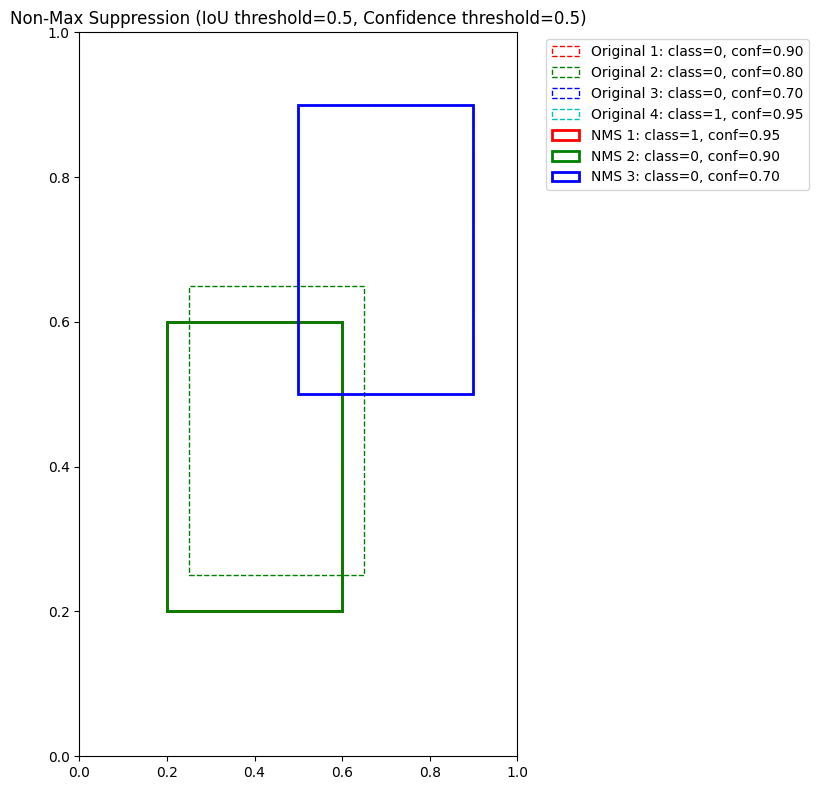

In [8]:
# Create example bounding boxes
# Format: [class_pred, prob_score, x1, y1, x2, y2] in corners format
bboxes = [
    [0, 0.9, 0.2, 0.2, 0.6, 0.6],  # High confidence box
    [0, 0.8, 0.25, 0.25, 0.65, 0.65],  # Overlapping box, same class
    [0, 0.7, 0.5, 0.5, 0.9, 0.9],  # Different location, same class
    [1, 0.95, 0.2, 0.2, 0.6, 0.6],  # Same location, different class
    [0, 0.3, 0.2, 0.2, 0.6, 0.6],  # Low confidence, will be filtered
]

# Apply NMS
iou_threshold = 0.5
confidence_threshold = 0.5
nms_boxes = non_max_suppression(bboxes, iou_threshold, confidence_threshold, box_format="corners")

# Print results
print("Before NMS:", len(bboxes), "boxes")
print("After NMS:", len(nms_boxes), "boxes")
for i, box in enumerate(nms_boxes):
    print(f"Box {i+1}: class={int(box[0])}, confidence={box[1]:.2f}, coords={box[2:]}")

# Visualize the boxes
fig, ax = plt.subplots(1, figsize=(8, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

# Plot original boxes
colors = ['r', 'g', 'b', 'c', 'm']
for i, box in enumerate(bboxes):
    if box[1] > confidence_threshold:
        rect = patches.Rectangle(
            (box[2], box[3]), 
            box[4]-box[2], 
            box[5]-box[3], 
            linewidth=1, 
            edgecolor=colors[i % len(colors)], 
            facecolor='none', 
            linestyle='--',
            label=f"Original {i+1}: class={int(box[0])}, conf={box[1]:.2f}"
        )
        ax.add_patch(rect)

# Plot NMS boxes with solid lines
for i, box in enumerate(nms_boxes):
    rect = patches.Rectangle(
        (box[2], box[3]), 
        box[4]-box[2], 
        box[5]-box[3], 
        linewidth=2, 
        edgecolor=colors[i % len(colors)], 
        facecolor='none',
        label=f"NMS {i+1}: class={int(box[0])}, conf={box[1]:.2f}"
    )
    ax.add_patch(rect)

ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Non-Max Suppression (IoU threshold={iou_threshold}, Confidence threshold={confidence_threshold})")
plt.tight_layout()
plt.show()

In [9]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [37]:
# Create example prediction boxes
# Format: [image_idx, class, confidence, x1, y1, x2, y2]
pred_boxes = [
    [0, 0, 0.9, 0.2, 0.2, 0.6, 0.6],  # Image 0, class 0, high confidence
    [0, 0, 0.8, 0.25, 0.25, 0.65, 0.65],  # Image 0, class 0, medium confidence
    [0, 1, 0.95, 0.5, 0.5, 0.9, 0.9],  # Image 0, class 1, high confidence
    [1, 0, 0.7, 0.1, 0.1, 0.4, 0.4],   # Image 1, class 0, medium confidence
    [1, 1, 0.65, 0.7, 0.1, 0.9, 0.3],  # Image 1, class 1, medium confidence
]

# Create example ground truth boxes
# Format: [image_idx, class, x1, y1, x2, y2]
true_boxes = [
    [0, 0, 0.2, 0.2, 0.6, 0.6],      # Image 0, class 0
    [0, 1, 0.5, 0.5, 0.85, 0.85],    # Image 0, class 1
    [1, 0, 0.15, 0.15, 0.45, 0.45],  # Image 1, class 0
    [1, 1, 0.7, 0.1, 0.95, 0.3],     # Image 1, class 1
]

# Calculate mAP
mAP = mean_average_precision(
    pred_boxes=pred_boxes,
    true_boxes=true_boxes,
    iou_threshold=0.5,
    box_format="corners",
    num_classes=2
)

print(f"Mean Average Precision: {mAP:.4f}")

RuntimeError: Boolean value of Tensor with no values is ambiguous

In [10]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    if len(im.shape)==3 and im.shape[0]<5: im=im.transpose(1,2,0)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [14]:
def get_bboxes(
    loader,
    model,
    iou_threshold,
    threshold,
    pred_format="cells",
    box_format="midpoint",
    device=DEVICE,
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [15]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

## Data Loader

In [16]:
train_csv = Path('../train.csv')

In [17]:
"""
Creates a Pytorch dataset to load the Pascal VOC dataset
"""

import torch
import os
import pandas as pd
from PIL import Image


class VOCDataset(torch.utils.data.Dataset):
    def __init__(
        self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None,
    ):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            # image = self.transform(image)
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            # i,j represents the cell row and cell column
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            """
            Calculating the width and height of cell of bounding box,
            relative to the cell is done by the following, with
            width as the example:
            
            width_pixels = (width*self.image_width)
            cell_pixels = (self.image_width)
            
            Then to find the width relative to the cell is simply:
            width_pixels/cell_pixels, simplification leads to the
            formulas below.
            """
            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            # If no object already found for specific cell i,j
            # Note: This means we restrict to ONE object
            # per cell!
            if label_matrix[i, j, 20] == 0:
                # Set that there exists an object
                label_matrix[i, j, 20] = 1

                # Box coordinates
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, 21:25] = box_coordinates

                # Set one hot encoding for class_label
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [20]:
pd.read_csv("data/8examples.csv")

,img,label
0,000007.jpg,000007.txt
1,000009.jpg,000009.txt
2,000016.jpg,000016.txt
3,000019.jpg,000019.txt
4,000020.jpg,000020.txt
5,000021.jpg,000021.txt
6,000122.jpg,000122.txt
7,000129.jpg,000129.txt


## Architecture

In [22]:
""" 
Information about architecture config:
Tuple is structured by (kernel_size, filters, stride, padding) 
"M" is simply maxpooling with stride 2x2 and kernel 2x2
List is structured by tuples and lastly int with number of repeats
"""
architecture_config = [
    (7, 64, 2, 3),  # (Kernel_sz, filters, stride, padding)
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


In [23]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [24]:
CNNBlock(1, 32, kernel_size=1, stride=1, padding=0)

CNNBlock(
  (conv): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leakyrelu): LeakyReLU(negative_slope=0.1)
)

In [25]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [26]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20)
model

Yolov1(
  (darknet): Sequential(
    (0): CNNBlock(
      (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): CNNBlock(
      (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
    )
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): CNNBlock(
      (conv): Conv2d(192, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batchnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leakyrelu): LeakyReLU(negative_slope=0.1)
  

## Loss function

In [27]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper and VOC dataset is 20),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)  # (bs, S, S, 30)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 20].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )

        box_targets = exists_box * target[..., 21:25]

        # Take sqrt of width, height of boxes to ensure that
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        # (N,S,S,4) -> (N*S*S, 4)
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        # (N*S*S)
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        # (N,S,S,1) -> (S*S)
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        # (N,S,S,20) -> (N*S*S,20)
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

In [28]:
S=7; B=2; C=20
lambda_noobj = 0.5
lambda_coord = 5
predictions = torch.randn(1, 7, 7, 30)
target = torch.randn(1, 7, 7, 25)

predictions = predictions.reshape(-1, S, S, C + B * 5)  # (bs, S, S, 30)
predictions.shape

torch.Size([1, 7, 7, 30])

## Train

In [29]:
"""
Main file for training Yolo model on Pascal VOC dataset

"""

import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 15
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"

In [30]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

In [31]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [33]:
train_dataset = VOCDataset(
    "data/8examples.csv",
    transform=transform,
    img_dir=IMG_DIR,
    label_dir=LABEL_DIR,
)
# train_dataset[0]

In [34]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "data/8examples.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False,
    )

    for epoch in range(EPOCHS):
        # for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.2
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Train mAP: {mean_avg_prec}")

        if mean_avg_prec > 0.9:
           checkpoint = {
               "state_dict": model.state_dict(),
               "optimizer": optimizer.state_dict(),
           }
           save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
           import time
           time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)

In [38]:
# main()

In [46]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=False,
)
xb, yb = next(iter(train_loader))
xb.shape

torch.Size([8, 3, 448, 448])

In [45]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

xb, yb = next(iter(train_loader))

with torch.no_grad(): 
    preds = model(xb)

bs = xb.shape[0]
bs

8

Inside `get_bboxes`.

In [70]:
all_pred_boxes = []
all_true_boxes = []
train_idx = 0

In [48]:
true_bboxes = cellboxes_to_boxes(yb)
true_bboxes

[[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.1428571492433548, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.2857142984867096, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.4285714626312256, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.5714285969734192, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.7142857313156128, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.8571429252624512, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.1428571492433548, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.2857142984867096, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.4285714626312256, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.5714285969734192, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.7142857313156128, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.8571429252624512, 0.1428571492433548, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.2857142984867096, 0.0, 0.0],
  [0.0, 0.0, 0.1428571492433548, 0.2857142984867096, 0.0, 0.0],
  [0.0, 0.0, 0.2857142984867096, 0.2857142984867096, 0.0, 0.0],
  [0.0, 0.0, 0.4285714626312256, 0.2857142984867096, 0.0, 0.0]

In [79]:
len(true_bboxes)

8

In [54]:
bboxes = cellboxes_to_boxes(preds)
bboxes[0]

[[15.0,
  0.06920987367630005,
  -0.01607995107769966,
  0.020498989149928093,
  -0.004772033076733351,
  0.0035818014293909073],
 [12.0,
  0.06876926869153976,
  0.156358003616333,
  -0.001929808990098536,
  0.011828566901385784,
  -0.02206849306821823],
 [18.0,
  0.15289777517318726,
  0.27977630496025085,
  0.018276939168572426,
  0.00393008254468441,
  -0.01979629322886467],
 [10.0,
  0.24337172508239746,
  0.4320497512817383,
  -0.03228488937020302,
  -0.005653462838381529,
  0.03994264081120491],
 [5.0,
  0.43560779094696045,
  0.5975209474563599,
  0.014091062359511852,
  -0.024846425279974937,
  -0.010986393317580223],
 [6.0,
  -0.18202660977840424,
  0.7037902474403381,
  0.04193349555134773,
  -0.004478197079151869,
  -0.058026425540447235],
 [16.0,
  0.18775711953639984,
  0.8512603640556335,
  0.03445281833410263,
  -0.0057342927902936935,
  -0.009735768660902977],
 [12.0,
  -0.03139827400445938,
  -0.0012935376726090908,
  0.13613200187683105,
  0.013999694027006626,
  0.0

In [56]:
len(bboxes[0]) # 1 per each cell

49

In [65]:
box_format = 'midpoint'
threshold = 0.1
iou_threshold = 0.1

In [66]:
idx = 0

nms_boxes = non_max_suppression(
    bboxes[idx],
    iou_threshold=iou_threshold,
    threshold=threshold,
    box_format=box_format,
)
nms_boxes

[[5.0,
  0.43560779094696045,
  0.5975209474563599,
  0.014091062359511852,
  -0.024846425279974937,
  -0.010986393317580223],
 [19.0,
  0.27705714106559753,
  0.7134982347488403,
  0.5621246695518494,
  0.0012870428618043661,
  -0.026914067566394806],
 [3.0,
  0.265550434589386,
  0.5681911706924438,
  0.13395783305168152,
  0.026898160576820374,
  0.019857952371239662],
 [0.0,
  0.25071364641189575,
  0.1300962269306183,
  0.6081552505493164,
  0.0448988638818264,
  -0.016867665573954582],
 [10.0,
  0.24667224287986755,
  0.8296687006950378,
  0.13273602724075317,
  0.01181754283607006,
  -0.0028124467935413122],
 [10.0,
  0.24337172508239746,
  0.4320497512817383,
  -0.03228488937020302,
  -0.005653462838381529,
  0.03994264081120491],
 [1.0,
  0.24168133735656738,
  0.5867652297019958,
  0.6841252446174622,
  0.011678709648549557,
  0.04495210573077202],
 [14.0,
  0.22273047268390656,
  0.31657975912094116,
  0.5807632207870483,
  -0.004448156803846359,
  -0.03518645465373993],
 [1

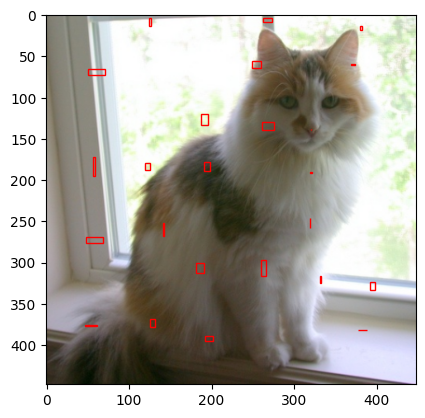

[[5.0, 0.43560779094696045, 0.5975209474563599, 0.014091062359511852, -0.024846425279974937, -0.010986393317580223], [19.0, 0.27705714106559753, 0.7134982347488403, 0.5621246695518494, 0.0012870428618043661, -0.026914067566394806], [3.0, 0.265550434589386, 0.5681911706924438, 0.13395783305168152, 0.026898160576820374, 0.019857952371239662], [0.0, 0.25071364641189575, 0.1300962269306183, 0.6081552505493164, 0.0448988638818264, -0.016867665573954582], [10.0, 0.24667224287986755, 0.8296687006950378, 0.13273602724075317, 0.01181754283607006, -0.0028124467935413122], [10.0, 0.24337172508239746, 0.4320497512817383, -0.03228488937020302, -0.005653462838381529, 0.03994264081120491], [1.0, 0.24168133735656738, 0.5867652297019958, 0.6841252446174622, 0.011678709648549557, 0.04495210573077202], [14.0, 0.22273047268390656, 0.31657975912094116, 0.5807632207870483, -0.004448156803846359, -0.03518645465373993], [1.0, 0.2022121548652649, 0.41554486751556396, 0.6840463280677795, -0.020989589393138885, 

In [67]:
plot_image(xb[idx].permute(1,2,0).to("cpu"), nms_boxes)
print(nms_boxes)

In [71]:
for nms_box in nms_boxes:
    all_pred_boxes.append([train_idx] + nms_box)

In [72]:
all_pred_boxes

[[0,
  5.0,
  0.43560779094696045,
  0.5975209474563599,
  0.014091062359511852,
  -0.024846425279974937,
  -0.010986393317580223],
 [0,
  19.0,
  0.27705714106559753,
  0.7134982347488403,
  0.5621246695518494,
  0.0012870428618043661,
  -0.026914067566394806],
 [0,
  3.0,
  0.265550434589386,
  0.5681911706924438,
  0.13395783305168152,
  0.026898160576820374,
  0.019857952371239662],
 [0,
  0.0,
  0.25071364641189575,
  0.1300962269306183,
  0.6081552505493164,
  0.0448988638818264,
  -0.016867665573954582],
 [0,
  10.0,
  0.24667224287986755,
  0.8296687006950378,
  0.13273602724075317,
  0.01181754283607006,
  -0.0028124467935413122],
 [0,
  10.0,
  0.24337172508239746,
  0.4320497512817383,
  -0.03228488937020302,
  -0.005653462838381529,
  0.03994264081120491],
 [0,
  1.0,
  0.24168133735656738,
  0.5867652297019958,
  0.6841252446174622,
  0.011678709648549557,
  0.04495210573077202],
 [0,
  14.0,
  0.22273047268390656,
  0.31657975912094116,
  0.5807632207870483,
  -0.00444815

In [75]:
true_bboxes[idx]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.1428571492433548, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.2857142984867096, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.4285714626312256, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.5714285969734192, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.7142857313156128, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.8571429252624512, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.1428571492433548, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.2857142984867096, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.4285714626312256, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.5714285969734192, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.7142857313156128, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.8571429252624512, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.1428571492433548, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.2857142984867096, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.4285714626312256, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.57

In [73]:
for box in true_bboxes[idx]:
    # many will get converted to 0 pred
    if box[1] > threshold:
        all_true_boxes.append([train_idx] + box)

Additional train_idx is added for `all_true_boxes`.

In [83]:
all_true_boxes

[[0,
  7.0,
  1.0,
  0.48842108249664307,
  0.512499988079071,
  0.8294737339019775,
  0.9458333849906921]]

In [84]:
len(true_bboxes[0])

49

In [81]:
true_bboxes[0]

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.1428571492433548, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.2857142984867096, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.4285714626312256, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.5714285969734192, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.7142857313156128, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.8571429252624512, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.1428571492433548, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.2857142984867096, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.4285714626312256, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.5714285969734192, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.7142857313156128, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.8571429252624512, 0.1428571492433548, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.1428571492433548, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.2857142984867096, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.4285714626312256, 0.2857142984867096, 0.0, 0.0],
 [0.0, 0.0, 0.57

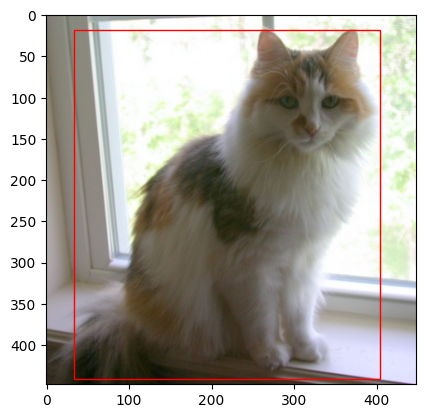

In [85]:
plot_image(xb[0], true_bboxes[0])

AssertionError: Got more values than in x, y, w, h, in a box!

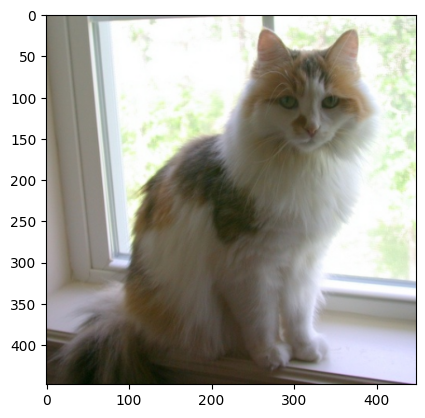

In [82]:
plot_image(xb[0], all_true_boxes)

Inside of `mean_average_precision`